In [88]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist
import imageio

from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI
from lib.analysis.align import ImageAlign
from lib.utilities import *
# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


In [57]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/11-30-23/selected_zda/"
target_recording = '03_03_03'
# input files: *_preStim.dat, *_amp.dat, *_snr.dat
cluster_SNRcutoff = 1
k_choice = 4  # none is auto

ROI_px_cutoff = 3
SNR_cutoff = 2
Amp_cutoff = 1

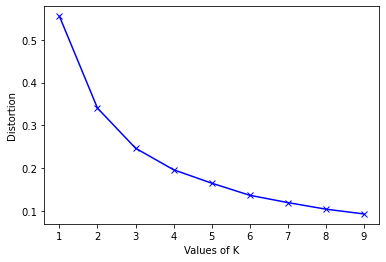

In [30]:
# elbow plot
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = data['_snr.dat'].reshape((-1,1))

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.show()

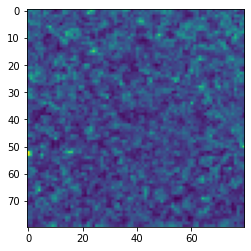

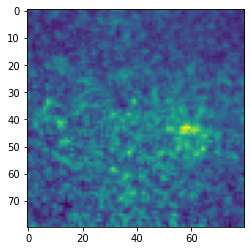

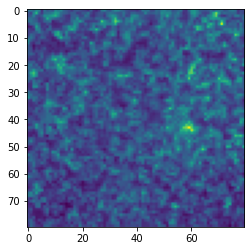

[[1 1 1 ... 0 2 2]
 [2 0 1 ... 0 2 0]
 [2 2 1 ... 1 2 1]
 ...
 [2 1 0 ... 0 0 0]
 [0 1 2 ... 0 2 0]
 [0 1 2 ... 0 2 0]]


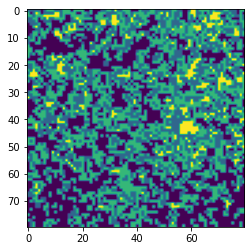

In [54]:
# Step1 produce: Density plot of SNR for all pixels,
#         K-means clustering plot of heatmap with cutoff applied
# Step2 produce: remove ROIs with diameters > cutoff

data = {}
for fn in ['_preStim.dat', '_amp.dat', '_snr.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr

# K-means cluster on SNR data
km = KMeans(n_clusters=k_choice)
km.fit(data['_snr.dat'].reshape((-1,1)))
labels = km.predict(data['_snr.dat'].reshape((-1,1)))
labels = labels.reshape((80,80))
plt.imshow(labels)
print(labels)
plt.show()

[[2.20515  2.41038  2.09573  ... 0.970787 1.36688  1.39828 ]
 [1.6411   1.2133   2.70792  ... 1.09272  1.55072  1.26074 ]
 [1.47044  1.73952  2.74615  ... 2.48544  1.70288  1.97685 ]
 ...
 [1.43423  1.99484  1.08432  ... 0.733479 0.924023 0.969441]
 [1.21835  2.03404  1.52246  ... 1.01072  1.29736  0.729544]
 [0.927827 2.07504  1.46725  ... 0.741894 1.35746  1.01405 ]]
[[2.20515  2.41038  2.09573  ... 0.970787 1.36688  1.39828 ]
 [1.6411   1.2133   2.70792  ... 1.09272  1.55072  1.26074 ]
 [1.47044  1.73952  2.74615  ... 2.48544  1.70288  1.97685 ]
 ...
 [1.43423  1.99484  1.08432  ... 0.733479 0.924023 0.969441]
 [1.21835  2.03404  1.52246  ... 1.01072  1.29736  0.729544]
 [0.927827 2.07504  1.46725  ... 0.741894 1.35746  1.01405 ]]
[[2.20515  2.41038  2.09573  ... 0.970787 1.36688  1.39828 ]
 [1.6411   1.2133   2.70792  ... 1.09272  1.55072  1.26074 ]
 [1.47044  1.73952  2.74615  ... 2.48544  1.70288  1.97685 ]
 ...
 [1.43423  1.99484  1.08432  ... 0.733479 0.924023 0.969441]
 [1.218

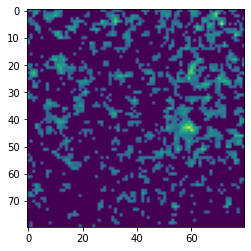

In [55]:
def get_cluster_value(k, labels, values):
    print(values)
    n, m = labels.shape
    ls = []
    for i in range(n):
        for j in range(m):
            if k == labels[i][j]:
                ls.append(values[i][j])
    return np.mean(ls)
                
snr = data['_snr.dat']
amp = data['_amp.dat']
cluster_snrs = [get_cluster_value(k, labels, data['_snr.dat']) for k in range(k_choice)]
for i in range(len(cluster_snrs)):
    if cluster_snrs[i] < cluster_SNRcutoff:
        print("remove cluster", i, "cluster SNR:", cluster_snrs[i])
        snr[labels == i] = 0

snr[snr < SNR_cutoff] = 0
snr[amp < Amp_cutoff] = 0
plt.imshow(snr)

[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1]


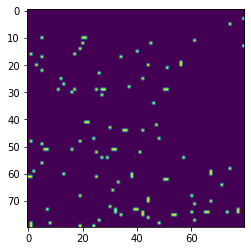

106.0


In [99]:
# pixel size cutoffs

def get_ROI(i, j, snr, visited):
    """ marks all contiguous pixels visited in the process """
    n, m = snr.shape
    visited[i][j] = 1
    if snr[i][j] == 0:
        return []
    roi = [[i, j]]
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            ii = i + dx 
            jj = j + dy
            if 0 <= ii < n and 0 <= jj < m and visited[ii][jj] == 0:
                roi +=  get_ROI(ii, jj, snr, visited)
    return roi
    
n, m = snr.shape
visited = np.zeros((n, m))
survivors = []
for i in range(n):
    for j in range(m):
        if visited[i][j] == 0:
            roi = get_ROI(i, j, snr, visited)
            if 0 < len(roi) < ROI_px_cutoff:
                survivors.append(roi)
print([len(s) for s in survivors])
kkm_roi_map = np.zeros((n, m))
for roi in survivors:
    for px in roi:
        i, j = px
        kkm_roi_map[i][j] = 1
        
plt.imshow(kkm_roi_map)
plt.show()
print(np.sum(kkm_roi_map))

(2, 160, 160, 4)


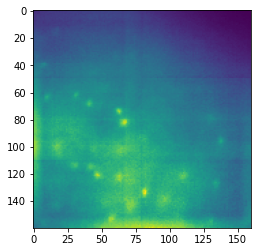

[[3233, 3313], [2911, 2991], [3828, 3829, 3908], [5320, 5400, 5321], [4823, 4743, 4824], [2660, 2740], [2415, 2495], [5107, 5106], [4854, 4853], [4495, 4574, 4575], [2485, 2564, 2484], [4911, 4910, 4831, 3185, 3184, 3264], [6224, 6304], [6108, 6109, 6188], [4580, 4581, 4500], [1524, 1603, 1604], [4008, 4009, 4088]] 17
[[[33, 40], [33, 41]], [[31, 36], [31, 37]], [[68, 47], [69, 47], [68, 48]], [[40, 66], [40, 67], [41, 66]], [[23, 60], [23, 59], [24, 60]], [[20, 33], [20, 34]], [[15, 30], [15, 31]], [[67, 63], [66, 63]], [[54, 60], [53, 60]], [[15, 56], [14, 57], [15, 57]], [[5, 31], [4, 32], [4, 31]], [[31, 61], [30, 61], [31, 60], [65, 39], [64, 39], [64, 40]], [[64, 77], [64, 78]], [[28, 76], [29, 76], [28, 77]], [[20, 57], [21, 57], [20, 56]], [[4, 19], [3, 20], [4, 20]], [[8, 50], [9, 50], [8, 51]]] 17


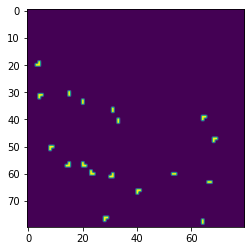

47.0


In [100]:
# read in tdTomato 
td_tomato_file_dir = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/11-30-23/selected_zda/03_03_06_crop_brightness.tif'
tdTomato_rois = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/11-30-23/converted_zda/ROIs_03_03_03_red.dat'
img = io.imread(td_tomato_file_dir)
print(img.shape)
if len(img.shape) == 3:
    img = np.average(img, axis=2)
elif len(img.shape) == 4:
    img = np.average(img, axis=0)
    img = np.average(img, axis=2)
plt.imshow(img)
plt.show()

rfr = ROIFileReader(tdTomato_rois)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))

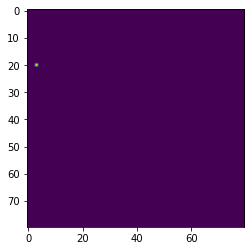

1


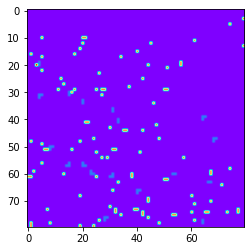

In [104]:
# overlap of red_roi_map and kkm_roi_map
overlap_map = np.logical_and(red_roi_map, kkm_roi_map)
plt.imshow(overlap_map)
plt.show()
print(np.sum(overlap_map))

superpose_map = red_roi_map + kkm_roi_map*5
plt.imshow(superpose_map, cmap='rainbow')